- Load the data
- Explore the Data format
- Create a vocabulary

In [334]:
import pickle
import numpy as np

In [335]:
with open('train_qa.txt', 'rb') as f: #rb = read binary
  train_data = pickle.load(f) #loading w pickle

In [336]:
with open('test_qa.txt', 'rb') as f: #rb = read binary
  test_data = pickle.load(f) #loading w pickle

In [337]:
type(train_data)

list

In [338]:
train_data

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
  'no'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.'],
  ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'],
  'no'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'went',
   'to',
   'the',
   'kitchen',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'bathroom',
   '.'],
  ['Is', 'Daniel', 'in', 'the', '

In [339]:
len(train_data)

10000

In [340]:
train_data[0] # 3 components: input/story, ques, ans

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [341]:
train_data[0][0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [342]:
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [343]:
all_data = train_data + test_data
#Building a word set to preprocess. not extracting answers

In [344]:
 #Set is an unordered collection of unique names
vocab = set()

for story, ques, answer in all_data:
  vocab = vocab.union(set(story)) #collecting distinct elems between vocub and story
  vocab = vocab.union(set(ques))

# Excluding 'ans' here, so no possibility of data leakage
# In production, my bot will face new stories/questions—it’s fair to preprocess all possible words upfront.

In [345]:
#Adding yes/no to the set
vocab.add('Yes')
vocab.add('No')

In [346]:
vocab_len = len(vocab) + 1 #PLACEHOLDER FOR KERAS

In [347]:
all_data[0][0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [348]:
# We need to determine the maximum story and question lengths for pad sequence
all_story_len = [len(data[0]) for data in all_data]

max_story_len = max(all_story_len)
max_ques_len = max([len(data[1]) for data in all_data  ])

In [349]:
max_story_len

156

In [350]:
max_ques_len

6

Vectorizing

In [351]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer

In [352]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab)

In [353]:
tokenizer.word_index

{'in': 1,
 'bedroom': 2,
 'put': 3,
 'kitchen': 4,
 'travelled': 5,
 'left': 6,
 'is': 7,
 'to': 8,
 'down': 9,
 'bathroom': 10,
 'office': 11,
 'moved': 12,
 'grabbed': 13,
 'apple': 14,
 'mary': 15,
 'picked': 16,
 'discarded': 17,
 'sandra': 18,
 'there': 19,
 'garden': 20,
 'got': 21,
 'john': 22,
 'milk': 23,
 'up': 24,
 'dropped': 25,
 'hallway': 26,
 'yes': 27,
 'no': 28,
 'the': 29,
 'went': 30,
 'journeyed': 31,
 'back': 32,
 'football': 33,
 'daniel': 34,
 'took': 35}

In [354]:
train_story_text = []
train_ques_text = []
train_ans_text = []

In [355]:
for story,ques,ans in train_data: #unzipping story,ques,ans
  train_story_text.append(story)
  train_ques_text.append(ques)
  train_ans_text.append(ans)

In [356]:
# converting into index

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [357]:
#train_story_text

In [358]:
#train_story_seq

In [359]:
len(train_story_seq)

10000

In [360]:
len(train_story_text)

10000

In [361]:
# We'll use pad_sequences to ensure all inputs have uniform length.
# RNNs/LSTMs require fixed-length inputs, so we'll pad shorter sequences with zeros.

def vectorize_stories(data,word_index=tokenizer.word_index,max_ques_len=max_ques_len, max_story_len=max_story_len):
  X = [] #for stories
  Xq = [] #for questions
  Y = [] #for ans yes/no

  for story,ques,ans in data: #passing data
    # for each story

    #Word indexing
    x = [word_index[word.lower()] for word in story if word.lower() in word_index]
    xq = [word_index[word.lower()] for word in ques if word.lower() in word_index]

    y = np.zeros(len(word_index)+1) #because this is just yes/no answer.

    y[word_index[ans]] = 1
    X.append(x)
    Xq.append(xq)
    Y.append(y)
  #returning unpackable tuple
  return (pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_ques_len),np.array(Y))


In [362]:
# Now I'll vectorize trainning and test data

train_story, train_ques, train_ans = vectorize_stories(train_data)
test_story, test_ques, test_ans = vectorize_stories(test_data)

In [363]:
train_ques

array([[ 0,  7, 18,  1, 29, 26],
       [ 0,  7, 34,  1, 29, 10],
       [ 0,  7, 34,  1, 29, 11],
       ...,
       [ 0,  7, 18,  1, 29, 26],
       [ 0,  7, 15,  1, 29,  4],
       [ 0,  7, 15,  1, 29,  2]], dtype=int32)

In [364]:
tokenizer.word_index['yes']

27

In [365]:
tokenizer.word_index['no']

28

In [366]:
sum(test_ans)
# There are 503 nos
# 497 yess

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 497., 503.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.])

- Building the neural Network
  - Input Encoder M
  - Input Encoder C
  - Question Encoder
- Complete Network

In [367]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [368]:
# PLACEHOLDER shape=(max_story_len, batch_size)
# Defining Input layers

input_sequence = Input((max_story_len,))
input_ques = Input((max_ques_len,))

In [369]:
# vocab_len
vocab_size = len(vocab) + 1

In [370]:
#INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64)) #Adding 2 layers
input_encoder_m.add(Dropout(0.3)) # Provided percentage of neuron will randomly turned of during training, helps with overfitting issue

#OUTPUT
#(sample, story_maxlen, embedding_dim)

In [371]:
#INPUT ENCODER
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

#OUTPUT
#(sample, story_maxlen, max_ques_len)

In [372]:
#QUESTON ENCODER
ques_encoder = Sequential()
ques_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length = max_ques_len))
ques_encoder.add(Dropout(0.3))

#OUTPUT
#(samples,ques_maxlen, embedding_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [373]:
# ENCODED <---- ENCODER(INPUT)

input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
ques_encoded = ques_encoder(input_ques)

In [374]:
match = dot([input_encoded_m, ques_encoded], axes=(2,2)) #Dot fn, as a list passing the product i'll be taking for

# Explained in the paper End to end networking

In [375]:
# calling activation function on 'match'
match = Activation('softmax')(match)

In [376]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response) #permutes the dimensions of input according given pattern

In [377]:
answer = concatenate([response, ques_encoded])

In [378]:
answer # 'shape=(None, 6, 220)' obtained

<KerasTensor shape=(None, 6, 220), dtype=float32, sparse=False, name=keras_tensor_143>

In [379]:
answer = LSTM(32)(answer)

In [380]:
answer = Dropout(0.5)(answer)
answer = Dense(36, activation='softmax')(answer)

In [381]:
from tensorflow.keras.models import Model

# model definition
# model = Model(inputs=[story_input, ques_input], outputs=answer)

model = Model([input_sequence, input_ques], answer)
# This 'answer' links together all the encoders (encoder m, c, question)

In [382]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [383]:
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 156)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 156, 64)   │      2,432 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 6, 64)     │      2,432 │ input_layer_27[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 156, 6)    │          0 │ sequential_12[0]… │
│                     │                   │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 156, 6)    │          0 │ dot_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 156, 6)    │        228 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 156, 6)    │          0 │ activation_4[0][… │
│                     │                   │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, 6, 156)    │          0 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 6, 220)    │          0 │ permute_4[0][0],  │
│ (Concatenate)       │                   │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     32,384 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 32)        │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 36)        │      1,188 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,664 (151.03 KB)

 Trainable params: 38,664 (151.03 KB)

 Non-trainable params: 0 (0.00 B)

- Fit/Train the network
  - I'll load a pre-trained Network
- Plot out Training History
- Evaluate on Test Set
- Create own stories and questions

In [384]:
# Debuggin tip: Always check shapes before training:

print("Model output shape:", model.output_shape)  # Should be (None, 36) - layer numbers should match be it 36 or 38
print("Labels shape:", train_ans.shape)          # Should be (None, 36)
print("Story data shape:", train_story.shape)    # Should match Input()
print("Question data shape:", train_ques.shape)  # Should match Input()

Model output shape: (None, 36)
Labels shape: (10000, 36)
Story data shape: (10000, 156)
Question data shape: (10000, 6)


In [413]:
# IF YOU WANT TO TRAIN YOUR MODEL

# trainning on story inputs and question inputs
history = model.fit(
    [train_story, train_ques],  # Must be numpy arrays (training data)
    train_ans, # <--- THIS IS YOUR TARGET (shape=(None, 36))
    batch_size=32, # ✅ Common values: 32, 64, 128 (powers of 2 for GPU optimization).
    epochs=50,
    validation_data=([test_story, test_ques], test_ans) # (validation data)
    )

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5050 - loss: 0.6953 - val_accuracy: 0.4970 - val_loss: 0.6963
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4948 - loss: 0.6954 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5037 - loss: 0.6948 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5065 - loss: 0.6942 - val_accuracy: 0.5030 - val_loss: 0.6937
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5191 - loss: 0.6936 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4938 - loss: 0.6954 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4998 - loss: 0.6951 - val_accuracy: 0.5030 - val_loss: 0.6933
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4924 - loss: 0.6957 - val_

In [416]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


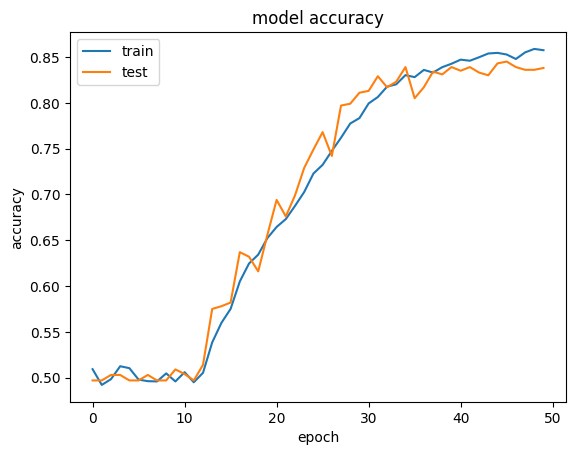

In [417]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [388]:
# If you want to save this model -> say model.save('some_sort_of_filepath.h5')
#model.save('mynewmodel.h5')

In [389]:
# NOW I WILL TRAIN THIS MODEL ON A PRE-TRAINED MODEL: chatbot_10.h5

In [418]:
model.load_weights(filename)
pred_results = model.predict(([ test_story,test_ques]))
#Input Order: Model expects [stories, questions]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [419]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [420]:
pred_results.shape

(1000, 36)

In [421]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [422]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [423]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [424]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.98949933


In [425]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'No',
 'Sandra',
 'Yes',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went'}

In [474]:
# Note the whitespace of the periods

my_story = "Elsa is in the kitchen . Eusuf dropped the football in the garden ."
my_story.split()

['Elsa',
 'is',
 'in',
 'the',
 'kitchen',
 '.',
 'Eusuf',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [475]:
my_ques = "Is Elsa in the garden ?"

In [476]:
my_ques.split()

['Is', 'Elsa', 'in', 'the', 'garden', '?']

In [477]:
mydata = [(my_story.split(), my_ques.split(), 'yes')]
# we expect 'yes' as the actual answer but do not notice that when we call model.predict(([my_story, my_ques])) we did not pass in my_ans. The algorithm will predict on its own.

In [478]:
mydata

[(['Elsa',
   'is',
   'in',
   'the',
   'kitchen',
   '.',
   'Eusuf',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'Elsa', 'in', 'the', 'garden', '?'],
  'yes')]

In [479]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [480]:
pred_results = model.predict(([ my_story,my_ques]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [481]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [482]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.9113774
